# Vorhersage der Solarenergieproduktion auf der Grundlage von Wetterdaten
Auf der Grundlage historischer Wetter- und Solardaten haben wir ein Regressionsmodell erstellt, um die zukünftige Solarenergieproduktion vorherzusagen. Dazu haben wir einen Datensatz aus einem Solarkraftwerk in Wandersleben analysiert und die Python-Bibliotheken Pandas, Matplotlib und Sklearn verwendet, um Erkenntnisse zu generieren und Zusammenhänge zwischen Energieproduktion und dem entsprechenden Wetter aufzuzeigen. Mit unserem Projekt wollen wir Möglichkeiten zur sauberen Energieerzeugung aufzeigen und damit einen Beitrag zum 7. nachhaltigen Entwicklungsziel - bezahlbare und saubere Energie - leisten.

**Keywords:** energy; weather; renewable.

In [1]:
from datetime import datetime
from geopy.geocoders import Nominatim
from meteostat import Point, Daily
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
%matplotlib inline

## 1. Einleitung
Derzeit sind in Deutschland knapp 2 Millionen Photovoltaikanlagen mit einer Leistung von 54 Gigawatt installiert. Im Jahr 2021 erzeugten sie 51 Terawattstunden Strom. Allerdings verbrauchte ganz Deutschland im gleichen Jahr 565 Terawattstunden Strom, 2021 kamen nur 8,6 Prozent des Strommixes aus der Solarenergie. Nur rund 32,7% aus erneuerbaren und klimafreundlichen Energien. Das zeigt deutlich, dass der Ausbau und die effizientere Nutzung der erneuerbaren Energien notwendig ist.

Viele sagen, dass die Überwachung und Vorhersage der photovoltaischen Energieerzeugung helfen wird, den Energieverlust zu reduzieren und mehr Energie zu nutzen. Aus diesem Grund haben wir die Projektidee entwickelt, die tägliche Solarstromproduktion einer kleinen Solaranlage vorherzusagen. Auf diese Weise können wir selbst einen kleinen Teil zu einer nachhaltigeren Zukunft beitragen.

Der erste Schritt in diesem Projekt bestand für uns darin, ein Ziel zu definieren, wir mussten uns überlegen, welches Thema uns interessieren würde. Für das Brainstorming benutzten wir Tools wie Miro, die uns im Workshop vorgeschlagen wurden, was uns half, eine Idee zu entwickeln. Während der gesamten Projektdauer verwendeten wir eine Kanban-Tafel, um die Aufgaben zu visualisieren und zuzuordnen. Nachdem wir das Ziel unseres Projekts festgelegt hatten, mussten wir Daten sammeln, was für uns die größte Herausforderung darstellte. Die "Rolf Fischer GmbH" war die Hauptquelle für die Datenerfassung der täglichen Solarstromerzeugung. Um unsere Wetterdaten zu sammeln, verwendeten wir das GeoPy Geoencoder-Paket und die Meteostat API. Nachdem wir die Daten aufbereitet und bereinigt hatten, z.B. durch Löschen fehlerhafter Spalten, haben wir einige grundlegende Datenanalysen und Visualisierungen mit den Paketen pandas und matplotlib durchgeführt. Im Folgenden haben wir unser lineares Regressionsmodell in einem Jupyter Notebook erstellt.

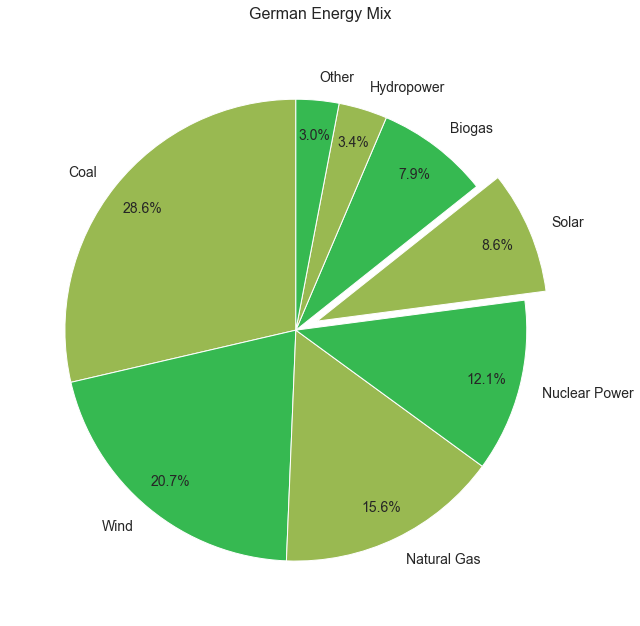

In [2]:
production = {'Coal': 286, 'Wind': 207, 'Natural Gas': 156, 'Nuclear Power': 121, 'Solar': 86, 
              'Biogas': 79, 'Hydropower': 34, 'Other': 30}
colors = ['#99b951', '#36b951', '#99b951', '#36b951', '#99b951', '#36b951', '#99b951', '#36b951']
fig, axs = plt.subplots(figsize=(9,9))
fig.suptitle('German Energy Mix', fontsize=16)
axs.pie(production.values(), explode=(0,0,0,0,0.1,0,0,0), labels=production.keys(), autopct='%1.1f%%', colors=colors,
        shadow=False, startangle=90, textprops={'fontsize': 14, 'rotation': 0}, pctdistance=0.85)
plt.tight_layout()
plt.show()

## 2. Data Engineering
Im ersten Schritt werden die exportierten Produktionsdaten zusammengefügt und mit den zugehörigen Wetterdaten kombiniert. Die Wetterdaten werden über die Meteostat API gezogen, bei der es sich um eine Open-Source-Datenbank mit tausenden Wetterstationen handelt. Aus dem Datum wird noch der Monat extrahiert, da dieser für die weitere Analyse der Daten und das Machine Learning eine wichtige Rolle spielt.

In [3]:
# Merge solar data of cities into a single file
def merge_files(folder: pathlib.Path) -> pd.DataFrame:
    result_df = None
    for file in [f for f in os.listdir(folder) if f.endswith('.csv')]:
        df = pd.read_csv(folder.joinpath(file), index_col=0, sep=';', decimal=',')
        if result_df is None:
            result_df = df
        else:
            result_df = pd.concat([result_df, df])
    result_df.reset_index(inplace=True)
    result_df.columns = ['Datum', 'Produktion']
    result_df['Datum'] = pd.to_datetime(result_df['Datum'])
    result_df.set_index('Datum', inplace=True)
    return result_df


def fetch_weather_data(city: str, start_date: datetime, end_date: datetime) -> pd.DataFrame:
    # Get the geolocation of the city
    location = Nominatim(user_agent='TechLabs').geocode(city)
    latitude, longitude = location.latitude, location.longitude

    # Create the Meteostat request and fetch the data
    request = Daily(loc=Point(lat=latitude, lon=longitude), start=start_date, end=end_date)
    return request.fetch()



solar_data = merge_files(folder=pathlib.Path('Data/Solar Wandersleben'))
weather_data = fetch_weather_data(city='Wandersleben', start_date=datetime(year=2014, month=1, day=1), end_date=datetime(year=2021, month=12, day=31))
dataset = solar_data.join(other=weather_data, how='inner').dropna().reset_index()
dataset['month'] = dataset['index'].dt.month
dataset.drop(columns='index', inplace=True)
dataset

,Produktion,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,month
0,117.928,6.7,3.7,10.7,0.1,0.0,213.0,32.4,66.6,1001.6,183.0,1
1,69.272,2.3,-0.7,4.7,1.1,0.0,229.0,21.2,48.2,1001.1,229.0,2
2,56.669,-8.8,-12.8,-4.3,0.0,0.0,66.0,19.1,43.9,1014.3,575.0,3
3,30.260,3.1,0.6,6.1,2.5,0.0,284.0,17.3,38.2,1006.0,53.0,4
4,24.557,9.3,4.1,13.4,0.0,0.0,230.0,27.4,61.9,1010.7,676.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1430,6.190,2.2,-0.2,4.5,2.8,20.0,165.0,10.5,30.2,1004.7,135.0,12
1431,59.979,5.0,3.7,6.7,0.4,0.0,200.0,18.4,48.2,998.0,10.0,12
1432,26.374,5.8,3.5,7.3,1.6,0.0,243.0,15.2,38.5,1005.4,0.0,12
1433,32.649,10.7,7.8,13.3,0.1,0.0,244.0,23.2,52.9,1014.8,10.0,12


## 3. Insight Generation
Die Erzeugung von Solarenergie ist sehr variabel und hängt von verschiedenen Faktoren ab. Daher ist es wichtig, die Erzeugung von Solarenergie genau vorherzusagen, um eine saubere und zuverlässige Energiequelle zu haben. Der Plan war, zu zeigen, wann an einem Standort die meiste Solarenergie zu erwarten ist. Dies sollte den Menschen die Entscheidung erleichtern, ob sich die Anschaffung einer Photovoltaikanlage lohnt. Außerdem sollte ermittelt werden können, welcher Energieertrag zu welchem Zeitpunkt zu erwarten ist, damit entsprechende Maßnahmen zur Nutzung der eigenen Energieversorgung ergriffen werden können.

Die Daten in den folgenden Abbildungen zeigen, dass es eine Korrelation zwischen Jahreszeit und Energieertrag gibt, was unseren Erwartungen entspricht. Außerdem scheinen die Daten viele Ausreißer zu haben, wie in der folgenden Grafik zu sehen ist. Aus diesem Grund liegt der mittlere absolute Fehler, der eine Kennzahl für die Genauigkeit des Modells ist und die durchschnittliche Abweichung des vorhergesagten Wertes vom tatsächlichen Wert beschreibt, bei 97,37 kWh und damit deutlich höher als erwartet.

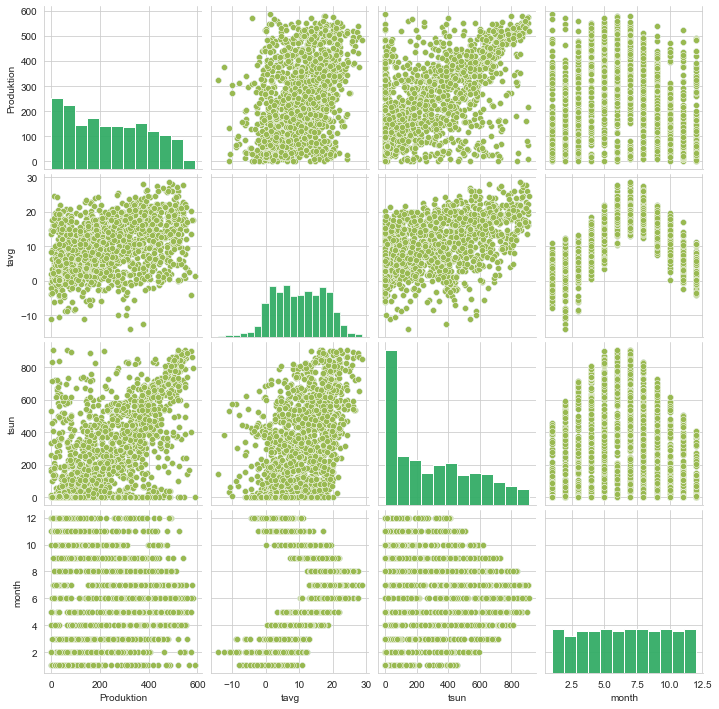

In [4]:
g = sns.pairplot(dataset[['Produktion', 'tavg', 'tsun', 'month']])
g.map_upper(sns.scatterplot,color='#99b951')
g.map_lower(sns.scatterplot, color='#99b951')
g.map_diag(sns.histplot, color='#36b951')
plt.show()

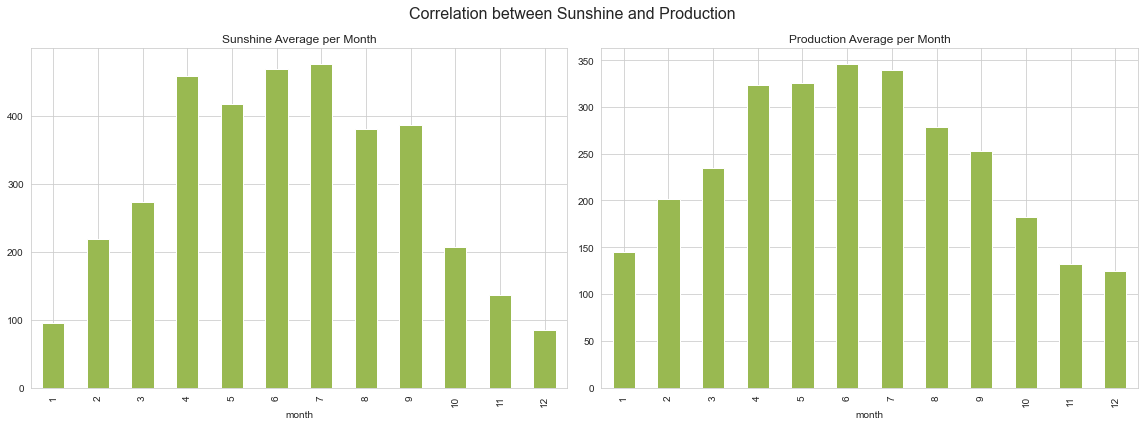

In [5]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 6))
fig.suptitle('Correlation between Sunshine and Production', fontsize=16)
dataset.groupby('month').tsun.mean().plot(kind='bar', ax=axs[0], color='#99b951')
axs[0].set(title='Sunshine Average per Month')
dataset.groupby('month').Produktion.mean().plot(kind='bar', ax=axs[1], color='#99b951')
axs[1].set(title='Production Average per Month')
plt.tight_layout()
plt.show()

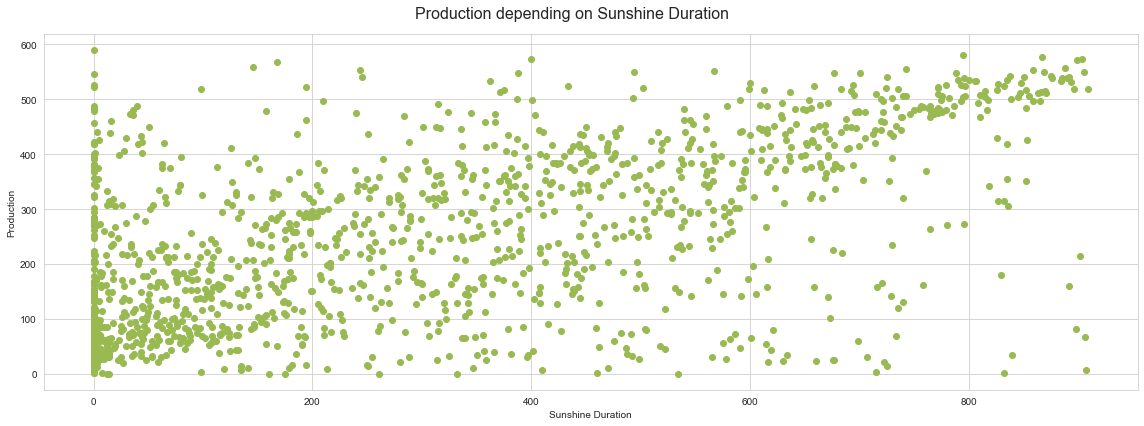

In [6]:
fig, axs = plt.subplots(figsize=(16,6))
fig.suptitle('Production depending on Sunshine Duration', fontsize=16)
axs.scatter(dataset['tsun'], dataset['Produktion'], color='#99b951')
axs.set(ylabel='Production', xlabel='Sunshine Duration')
plt.tight_layout()
plt.show()

## 4. Linear Regression Model
Für das Training der Linearen Regression wurden die Monate in Dummy Variablen umgewandelt, da es sich bei Monaten um keine wirkliche numerische Variable handelt. Anschließend wurden die Daten in Trainings- und Testdaten unterteilt, indem die ersten 70% des Zeitraum für das Training und der Rest für Evaluation genutzt werden. Aufgrund der Beschaffenheit der Daten kann die Regression mit einem Mean Absolute Error von etwa 92kW/h keine sehr genauen Vorhersagen treffen. Aus dem Histogramm ist ersichtlich, dass das Modell eher eine zu hohe Energieproduktion vorhersagt.

In [7]:
dataset = pd.get_dummies(data=dataset, columns=['month'])
dataset

,Produktion,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,117.928,6.7,3.7,10.7,0.1,0.0,213.0,32.4,66.6,1001.6,...,0,0,0,0,0,0,0,0,0,0
1,69.272,2.3,-0.7,4.7,1.1,0.0,229.0,21.2,48.2,1001.1,...,0,0,0,0,0,0,0,0,0,0
2,56.669,-8.8,-12.8,-4.3,0.0,0.0,66.0,19.1,43.9,1014.3,...,1,0,0,0,0,0,0,0,0,0
3,30.260,3.1,0.6,6.1,2.5,0.0,284.0,17.3,38.2,1006.0,...,0,1,0,0,0,0,0,0,0,0
4,24.557,9.3,4.1,13.4,0.0,0.0,230.0,27.4,61.9,1010.7,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430,6.190,2.2,-0.2,4.5,2.8,20.0,165.0,10.5,30.2,1004.7,...,0,0,0,0,0,0,0,0,0,1
1431,59.979,5.0,3.7,6.7,0.4,0.0,200.0,18.4,48.2,998.0,...,0,0,0,0,0,0,0,0,0,1
1432,26.374,5.8,3.5,7.3,1.6,0.0,243.0,15.2,38.5,1005.4,...,0,0,0,0,0,0,0,0,0,1
1433,32.649,10.7,7.8,13.3,0.1,0.0,244.0,23.2,52.9,1014.8,...,0,0,0,0,0,0,0,0,0,1


In [8]:
TRAIN_SIZE = 0.7
TEST_SIZE = 1 - TRAIN_SIZE

dataset.dropna(inplace=True)
X, y = dataset.drop(columns=['Produktion']), dataset['Produktion']
X_train, X_test = X.iloc[:int(len(X) * TRAIN_SIZE)], X.iloc[int(len(X) * TRAIN_SIZE):]
y_train, y_test = y.iloc[:int(len(X) * TRAIN_SIZE)], y.iloc[int(len(X) * TRAIN_SIZE):]

print(f'X-Train-Shape={X_train.shape} - y-Train-Shape={y_train.shape}')
print(f'X-Test-Shape={X_test.shape} - y-Test-Shape={y_test.shape}')

X-Train-Shape=(1004, 22) - y-Train-Shape=(1004,)
X-Test-Shape=(431, 22) - y-Test-Shape=(431,)


MAE is 92.37814674435144
MSE is 15254.500488109348
RMSE is 123.50911095182148


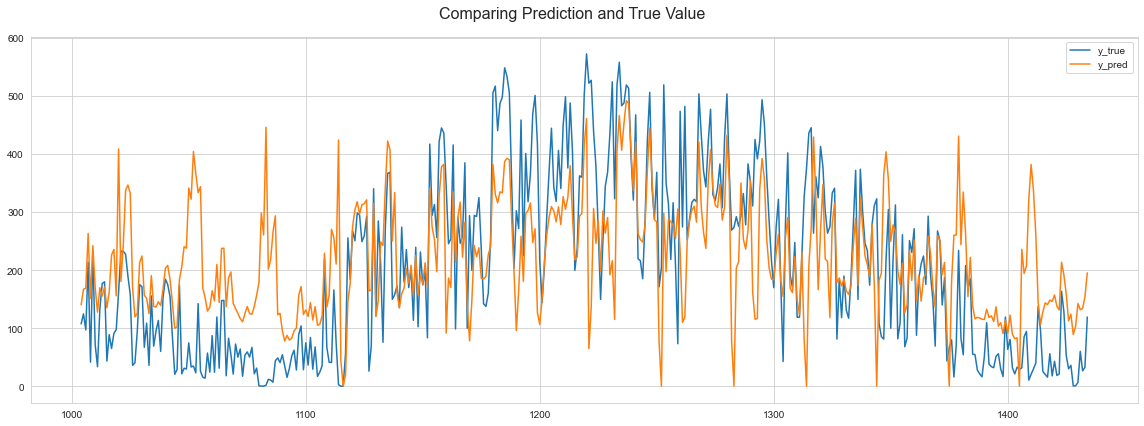

In [9]:
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the testset, setting all negative predictions to 0 since negative energy production is not possible
predictions = np.array([max(0, p) for p in model.predict(X_test)])
print(f'MAE is {mean_absolute_error(y_test, predictions)}')
print(f'MSE is {mean_squared_error(y_test, predictions)}')
print(f'RMSE is {mean_squared_error(y_test, predictions, squared=False)}')

eval_df = pd.DataFrame(data={'y_true': y_test, 'y_pred': predictions}, index=X_test.index)
fig, axs = plt.subplots(figsize=(16,6))
fig.suptitle('Comparing Prediction and True Value', fontsize=16)
eval_df.plot(kind='line', ax=axs)
plt.tight_layout()
plt.show()

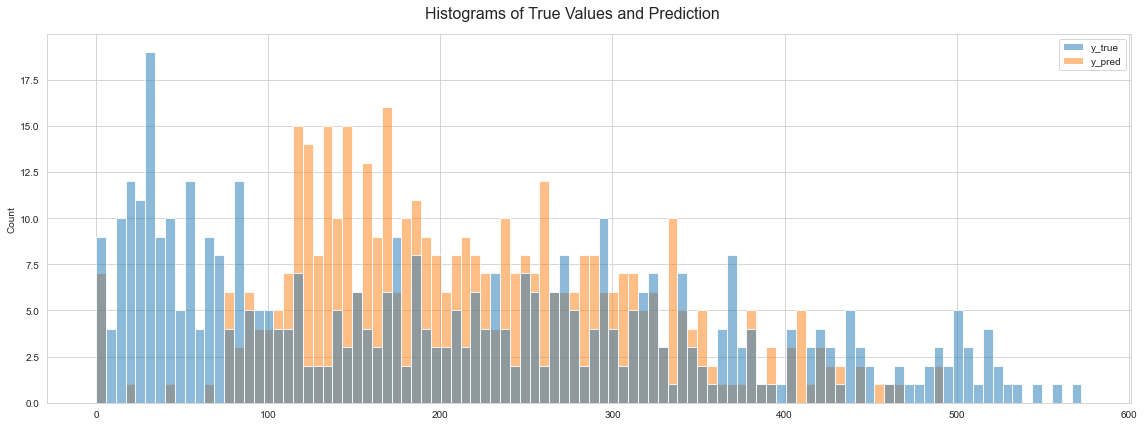

In [10]:
fig, axs = plt.subplots(figsize=(16,6))
fig.suptitle('Histograms of True Values and Prediction', fontsize=16)
sns.histplot(eval_df, bins=100, ax=axs)
plt.tight_layout()
plt.show()

## 5. Weitere Schritte
Zukünftige Schritte könnten darin bestehen, Ausreißer aus den Daten zu suchen und zu entfernen und so die Leistung des Modells zu verbessern, um eine höhere Genauigkeit zu erzielen. Eine weitere Möglichkeit wäre die Einbeziehung von Daten aus anderen Solarkraftwerken, um die Datenbasis zu erweitern.

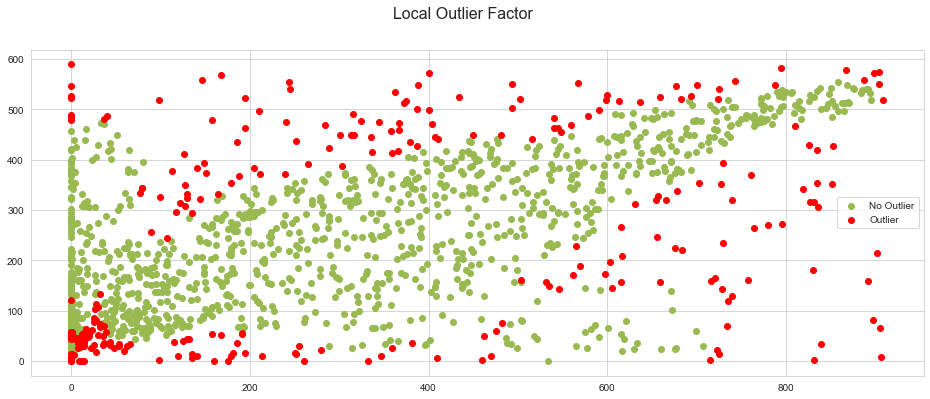

In [11]:
from sklearn.neighbors import LocalOutlierFactor
outlier = LocalOutlierFactor(n_neighbors=30, metric='euclidean', algorithm='brute', contamination=0.2).fit_predict(dataset[['tsun', 'Produktion']])
colors = ['#99b951' if o==1 else 'r' for o in outlier]

fig, axs = plt.subplots(figsize=(16,6))
fig.suptitle('Local Outlier Factor', fontsize=16)
axs.scatter(dataset.loc[np.where(outlier==1, True, False)].tsun, dataset[np.where(outlier==1, True, False)].Produktion, color='#99b951', label='No Outlier')
axs.scatter(dataset.loc[np.where(outlier!=1, True, False)].tsun, dataset[np.where(outlier!=1, True, False)].Produktion, color='r', label='Outlier')
axs.legend()
plt.show()